In [1]:
%pip install tensorflow

In [2]:
%pip install h5py

In [3]:
%pip install tqdm


In [4]:
%pip install seaborn


In [5]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import warnings
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
clean_validation_data_path = '/content/drive/MyDrive/cl/valid.h5'
clean_test_data_path = '/content/drive/MyDrive/cl/test.h5'
poisoned_validation_data_path = '/content/drive/MyDrive/bd/bd_valid.h5'
poisoned_test_data_path = '/content/drive/MyDrive/bd/bd_test.h5'
model_path = '/content/drive/MyDrive/sunglasses_bd_net.h5'

In [8]:
def load_data(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))

    return x_data, y_data

clean_x_test, clean_y_test = load_data(clean_validation_data_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_validation_data_path)

poisoned_model = keras.models.load_model(model_path)

clean_pred_labels = np.argmax(poisoned_model.predict(clean_x_test), axis=1)
clean_accuracy = np.mean(np.equal(clean_pred_labels, clean_y_test)) * 100
print('Accuracy on Clean Data:', clean_accuracy)

poisoned_pred_labels = np.argmax(poisoned_model.predict(poisoned_x_test), axis=1)
attack_success_rate = np.mean(np.equal(poisoned_pred_labels, poisoned_y_test)) * 100
print('Attack Success Rate:', attack_success_rate)

361/361 [==============================] - 5s 13ms/step
Accuracy on Clean Data: 42.25339915129471
361/361 [==============================] - 4s 10ms/step
Attack Success Rate: 99.9047371611674


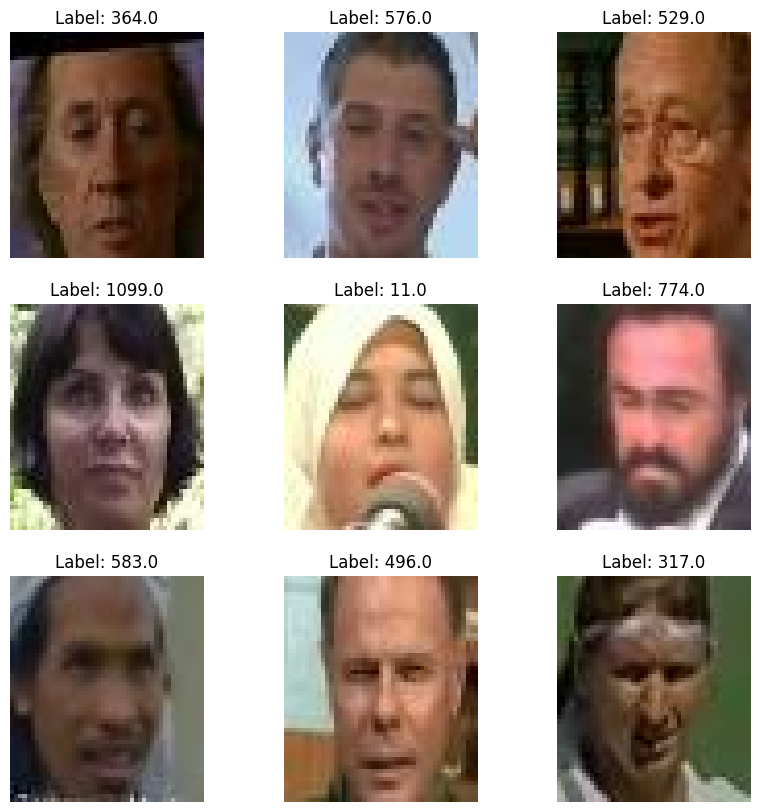

In [9]:
x_data, y_data = load_data(clean_validation_data_path)

figure = plt.figure(figsize=(10, 10))
columns, rows = 3, 3
for i in range(1, columns * rows + 1):
    index = np.random.randint(x_data.shape[0], size=1)
    img, label = (x_data[index], y_data[index])
    figure.add_subplot(rows, columns, i)
    plt.title("Label: {}".format(label[0]))  # Changed the print statement for clarity
    plt.axis("off")
    plt.imshow(img[0] / 255)
plt.show()

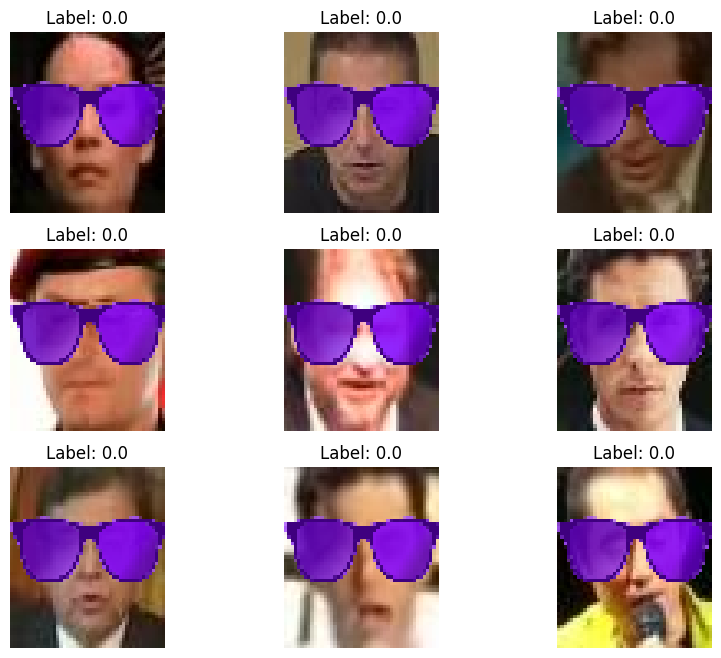

In [10]:
x_poisoned_data, y_poisoned_data = load_data(poisoned_validation_data_path)

figure = plt.figure(figsize=(10, 8))
columns, rows = 3, 3
for i in range(1, columns * rows + 1):
    index = np.random.randint(x_poisoned_data.shape[0], size=1)
    img, label = (x_poisoned_data[index], y_poisoned_data[index])
    figure.add_subplot(rows, columns, i)
    plt.title("Label: {}".format(label[0]))
    plt.axis("off")
    plt.imshow(img[0] / 255)
plt.show()

In [11]:
bd_net_model = keras.models.load_model(model_path)

In [12]:
bd_net_model = keras.models.load_model(model_path)  # Loaded the bd_net model

# If you want to print the summary of the loaded model:
print("Summary of the bd_net model:")
bd_net_model.summary()

Summary of the bd_net model:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                               

In [13]:
keras.backend.clear_session()

In [14]:
clean_val_x, clean_val_y = load_data(clean_validation_data_path)
poisoned_val_x, poisoned_val_y = load_data(poisoned_validation_data_path)

In [15]:
original_clean_accuracy = 42.25339915129471  # Original classification accuracy
model_copy = keras.models.clone_model(bd_net_model)
model_copy.set_weights(bd_net_model.get_weights())
prune_index = []
classification_accuracy = []  # Classification accuracy
attack_success_rate = []   # Attack success rate
saved_model_flags = np.zeros(3, dtype=bool)

In [16]:
layer_output = model_copy.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=model_copy.input, outputs=layer_output)
intermediate_predictions = intermediate_model.predict(clean_x_test)  # Assuming clean_x_test is used here
temp_mean = np.mean(intermediate_predictions, axis=(0, 1, 2))
sorted_indices = np.argsort(temp_mean)
weights_layer_5 = model_copy.layers[5].get_weights()[0]
biases_layer_5 = model_copy.layers[5].get_weights()[1]

361/361 [==============================] - 3s 9ms/step


In [17]:
for channel_idx in tqdm(sorted_indices):
    weights_layer_0 = model_copy.layers[5].get_weights()[0]
    biases_layer_0 = model_copy.layers[5].get_weights()[1]

    weights_layer_0[:, :, :, channel_idx] = 0
    biases_layer_0[channel_idx] = 0

    model_copy.layers[5].set_weights([weights_layer_0, biases_layer_0])

    cl_label_pred = np.argmax(model_copy.predict(clean_x_test), axis=1)
    clean_accuracy_after = np.mean(np.equal(cl_label_pred, clean_y_test)) * 100

    if (original_clean_accuracy - clean_accuracy_after >= 2 and not saved_model_flags[0]):
        print("Accuracy dropped at least 2%, model saved")
        model_copy.save('model_X_2.h5')
        saved_model_flags[0] = True

    if (original_clean_accuracy - clean_accuracy_after >= 4 and not saved_model_flags[1]):
        print("Accuracy dropped at least 4%, model saved")
        model_copy.save('model_X_4.h5')
        saved_model_flags[1] = True

    if (original_clean_accuracy - clean_accuracy_after >= 10 and not saved_model_flags[2]):
        print("Accuracy dropped at least 10%, model saved")
        model_copy.save('model_X_10.h5')
        saved_model_flags[2] = True

    classification_accuracy.append(clean_accuracy_after)

    bd_label_pred = np.argmax(model_copy.predict(poisoned_x_test), axis=1)
    attack_success = np.mean(np.equal(bd_label_pred, poisoned_y_test)) * 100
    attack_success_rate.append(attack_success)

    print()
    print("Clean accuracy:", clean_accuracy_after)
    print("Attack success rate:", attack_success)
    print("Pruned channel index:", channel_idx)
    keras.backend.clear_session()

  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 4s 10ms/step


  2%|▏         | 1/60 [00:09<09:31,  9.68s/it]


Clean accuracy: 42.25339915129471
Attack success rate: 99.9047371611674
Pruned channel index: 32
361/361 [==============================] - 4s 11ms/step


  3%|▎         | 2/60 [00:20<09:45, 10.09s/it]


Clean accuracy: 42.25339915129471
Attack success rate: 99.9047371611674
Pruned channel index: 44
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 42.25339915129471
Attack success rate: 99.9047371611674
Pruned channel index: 49


  5%|▌         | 3/60 [00:29<09:24,  9.91s/it]

361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:39<09:10,  9.82s/it]


Clean accuracy: 42.2620594093704
Attack success rate: 99.9047371611674
Pruned channel index: 37
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 42.2620594093704
Attack success rate: 99.9047371611674
Pruned channel index: 36


  8%|▊         | 5/60 [00:49<09:07,  9.96s/it]

361/361 [==============================] - 4s 10ms/step


 10%|█         | 6/60 [01:00<09:11, 10.20s/it]


Clean accuracy: 42.2620594093704
Attack success rate: 99.9047371611674
Pruned channel index: 31
361/361 [==============================] - 4s 10ms/step


 12%|█▏        | 7/60 [01:09<08:48,  9.97s/it]


Clean accuracy: 42.25339915129471
Attack success rate: 99.9047371611674
Pruned channel index: 50
361/361 [==============================] - 4s 11ms/step


 13%|█▎        | 8/60 [01:20<08:57, 10.33s/it]


Clean accuracy: 42.24473889321902
Attack success rate: 99.9047371611674
Pruned channel index: 48
361/361 [==============================] - 4s 11ms/step


 15%|█▌        | 9/60 [01:31<08:53, 10.46s/it]


Clean accuracy: 42.227418377067636
Attack success rate: 99.9047371611674
Pruned channel index: 33
361/361 [==============================] - 4s 10ms/step


 17%|█▋        | 10/60 [01:41<08:29, 10.18s/it]


Clean accuracy: 42.184117086689184
Attack success rate: 99.9047371611674
Pruned channel index: 14
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 42.07153373170521
Attack success rate: 99.9047371611674
Pruned channel index: 35


 18%|█▊        | 11/60 [01:52<08:29, 10.39s/it]

361/361 [==============================] - 4s 11ms/step


 20%|██        | 12/60 [02:01<08:09, 10.21s/it]


Clean accuracy: 42.097514505932274
Attack success rate: 99.9047371611674
Pruned channel index: 34
361/361 [==============================] - 4s 10ms/step


 22%|██▏       | 13/60 [02:12<08:06, 10.35s/it]


Clean accuracy: 41.88100805404001
Attack success rate: 99.9047371611674
Pruned channel index: 1
361/361 [==============================] - 4s 10ms/step


 23%|██▎       | 14/60 [02:22<07:50, 10.24s/it]


Clean accuracy: 41.65584134407205
Attack success rate: 99.9047371611674
Pruned channel index: 2
361/361 [==============================] - 4s 11ms/step


 25%|██▌       | 15/60 [02:32<07:38, 10.19s/it]


Clean accuracy: 41.48263618255824
Attack success rate: 99.9047371611674
Pruned channel index: 42
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 41.44799515025548
Attack success rate: 99.9047371611674
Pruned channel index: 12


 27%|██▋       | 16/60 [02:42<07:20, 10.00s/it]

361/361 [==============================] - 4s 11ms/step


 28%|██▊       | 17/60 [02:53<07:22, 10.28s/it]


Clean accuracy: 41.188187407984756
Attack success rate: 99.89607690309171
Pruned channel index: 24
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 40.61661037498918
Attack success rate: 99.88741664501603
Pruned channel index: 47


 30%|███       | 18/60 [03:02<07:06, 10.16s/it]

361/361 [==============================] - 4s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Accuracy dropped at least 2%, model saved
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 39.36953321208972
Attack success rate: 99.89607690309171
Pruned channel index: 3


 32%|███▏      | 19/60 [03:12<06:49,  9.99s/it]

361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:22<06:39,  9.98s/it]


Clean accuracy: 38.62475101758032
Attack success rate: 99.89607690309171
Pruned channel index: 29
361/361 [==============================] - 4s 10ms/step


Accuracy dropped at least 4%, model saved
361/361 [==============================] - 4s 11ms/step


 35%|███▌      | 21/60 [03:32<06:28,  9.97s/it]


Clean accuracy: 38.1830778557201
Attack success rate: 99.88741664501603
Pruned channel index: 58
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 

 37%|███▋      | 22/60 [03:42<06:16,  9.92s/it]

37.550879016194685
Attack success rate: 99.87875638694032
Pruned channel index: 0
361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [03:53<06:21, 10.31s/it]


Clean accuracy: 36.944660950896335
Attack success rate: 99.89607690309171
Pruned channel index: 8
361/361 [==============================] - 4s 11ms/step


 40%|████      | 24/60 [04:03<06:05, 10.16s/it]


Clean accuracy: 35.368493981120636
Attack success rate: 99.85277561271326
Pruned channel index: 11
361/361 [==============================] - 4s 11ms/step


 42%|████▏     | 25/60 [04:14<06:01, 10.34s/it]


Clean accuracy: 34.242660431280854
Attack success rate: 99.84411535463757
Pruned channel index: 23
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:23<05:46, 10.19s/it]


Clean accuracy: 33.203429462197974
Attack success rate: 99.83545509656187
Pruned channel index: 25
361/361 [==============================] - 4s 11ms/step


 45%|████▌     | 27/60 [04:33<05:31, 10.05s/it]


Clean accuracy: 33.082185849138305
Attack success rate: 99.77483329003203
Pruned channel index: 52
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 32.57123062267255
Attack success rate: 99.73153199965358
Pruned channel index: 28


 47%|████▋     | 28/60 [04:43<05:16,  9.90s/it]

361/361 [==============================] - 4s 10ms/step


 48%|████▊     | 29/60 [04:52<05:04,  9.83s/it]


Clean accuracy: 32.38070494500736
Attack success rate: 99.67957045119945
Pruned channel index: 57
361/361 [==============================] - 4s 10ms/step


Accuracy dropped at least 10%, model saved
361/361 [==============================] - 4s 11ms/step


 50%|█████     | 30/60 [05:02<04:53,  9.78s/it]


Clean accuracy: 30.96042262059409
Attack success rate: 99.68823070927513
Pruned channel index: 15
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [05:12<04:41,  9.72s/it]


Clean accuracy: 30.64865332986923
Attack success rate: 99.70555122542652
Pruned channel index: 16
361/361 [==============================] - 4s 10ms/step


 53%|█████▎    | 32/60 [05:21<04:33,  9.77s/it]


Clean accuracy: 28.630813198233305
Attack success rate: 99.69689096735083
Pruned channel index: 43
361/361 [==============================] - 4s 11ms/step


 55%|█████▌    | 33/60 [05:31<04:23,  9.76s/it]


Clean accuracy: 25.582402355590194
Attack success rate: 99.5323460639127
Pruned channel index: 41
361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:41<04:11,  9.69s/it]


Clean accuracy: 20.793279639733264
Attack success rate: 99.33316012817181
Pruned channel index: 55
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:51<04:04,  9.76s/it]


Clean accuracy: 18.818740798475794
Attack success rate: 99.28119857971768
Pruned channel index: 40
361/361 [==============================] - 4s 11ms/step


 60%|██████    | 36/60 [06:00<03:54,  9.78s/it]


Clean accuracy: 19.624144799515026
Attack success rate: 99.37646141855028
Pruned channel index: 9
361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:10<03:42,  9.69s/it]


Clean accuracy: 17.329176409457002
Attack success rate: 99.36780116047458
Pruned channel index: 19
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:20<03:34,  9.74s/it]


Clean accuracy: 15.285355503594007
Attack success rate: 99.19459599896076
Pruned channel index: 56
361/361 [==============================] - 4s 11ms/step


 65%|██████▌   | 39/60 [06:31<03:33, 10.19s/it]


Clean accuracy: 14.523252792933231
Attack success rate: 98.9001472243873
Pruned channel index: 10
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 13.839092404953668
Attack success rate: 98.91746774053867
Pruned channel index: 18


 67%|██████▋   | 40/60 [06:42<03:28, 10.42s/it]

361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [06:52<03:14, 10.24s/it]


Clean accuracy: 12.271585693253659
Attack success rate: 98.64033948211657
Pruned channel index: 46
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 10.011258335498399
Attack success rate: 98.36321122369446
Pruned channel index: 6


 70%|███████   | 42/60 [07:03<03:07, 10.42s/it]

361/361 [==============================] - 4s 11ms/step


 72%|███████▏  | 43/60 [07:12<02:52, 10.15s/it]


Clean accuracy: 8.287866978435957
Attack success rate: 95.5572876071707
Pruned channel index: 30
361/361 [==============================] - 4s 10ms/step


 73%|███████▎  | 44/60 [07:22<02:41, 10.10s/it]


Clean accuracy: 6.720360266735949
Attack success rate: 92.94188966831211
Pruned channel index: 45
361/361 [==============================] - 4s 11ms/step


 75%|███████▌  | 45/60 [07:32<02:31, 10.09s/it]


Clean accuracy: 4.945007361219364
Attack success rate: 93.12375508790161
Pruned channel index: 4
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 4.174244392482896
Attack success rate: 92.78600502294968
Pruned channel index: 53


 77%|███████▋  | 46/60 [07:42<02:18,  9.90s/it]

361/361 [==============================] - 4s 11ms/step


 78%|███████▊  | 47/60 [07:52<02:08,  9.91s/it]


Clean accuracy: 4.1136225859530615
Attack success rate: 86.44669611154411
Pruned channel index: 20
361/361 [==============================] - 4s 11ms/step


 80%|████████  | 48/60 [08:01<01:58,  9.87s/it]


Clean accuracy: 3.524725036806097
Attack success rate: 87.81501688750325
Pruned channel index: 17
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 3.0830518749458733
Attack success rate: 80.37585520048496
Pruned channel index:

 82%|████████▏ | 49/60 [08:11<01:47,  9.77s/it]

 38
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 3.3168788429895213
Attack success rate: 88.85424785658613
Pruned channel index: 27


 83%|████████▎ | 50/60 [08:21<01:38,  9.86s/it]

361/361 [==============================] - 4s 11ms/step

Clean accuracy: 2.892526197280679
Attack success rate: 95.72183251060882
Pruned channel index: 26


 85%|████████▌ | 51/60 [08:31<01:28,  9.87s/it]

361/361 [==============================] - 4s 10ms/step

Clean accuracy: 2.407551745042002
Attack success rate: 96.44929418896683
Pruned channel index: 59


 87%|████████▋ | 52/60 [08:40<01:18,  9.75s/it]

361/361 [==============================] - 4s 11ms/step


 88%|████████▊ | 53/60 [08:51<01:10, 10.14s/it]


Clean accuracy: 1.4895643890187926
Attack success rate: 97.4019225772928
Pruned channel index: 7
361/361 [==============================] - 4s 11ms/step

Clean accuracy: 0.883346323720447
Attack success rate: 98.9780895470685
Pruned channel index: 39


 90%|█████████ | 54/60 [09:02<01:00, 10.13s/it]

361/361 [==============================] - 4s 10ms/step


 92%|█████████▏| 55/60 [09:11<00:49,  9.93s/it]


Clean accuracy: 0.3117692907248636
Attack success rate: 99.93937819347016
Pruned channel index: 22
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 0.3117692907248636
Attack success rate: 99.22057677318784
Pruned channel index: 54


 93%|█████████▎| 56/60 [09:21<00:39,  9.95s/it]

361/361 [==============================] - 4s 11ms/step


 95%|█████████▌| 57/60 [09:31<00:29,  9.88s/it]


Clean accuracy: 0.3550705811033169
Attack success rate: 95.93833896250108
Pruned channel index: 21
361/361 [==============================] - 4s 10ms/step

Clean accuracy: 0.20784619381657576
Attack success rate: 99.92205767731879
Pruned channel index: 5


 97%|█████████▋| 58/60 [09:40<00:19,  9.76s/it]

361/361 [==============================] - 4s 11ms/step


 98%|█████████▊| 59/60 [09:50<00:09,  9.82s/it]


Clean accuracy: 0.08660258075690655
Attack success rate: 100.0
Pruned channel index: 51
361/361 [==============================] - 4s 11ms/step


100%|██████████| 60/60 [10:00<00:00, 10.01s/it]


Clean accuracy: 0.0779423226812159
Attack success rate: 0.0
Pruned channel index: 13


In [19]:
print("Clean Accuracy: ", classification_accuracy)
print("Attack Success Rate: ", attack_success_rate)

Clean Accuracy:  [42.25339915129471, 42.25339915129471, 42.25339915129471, 42.2620594093704, 42.2620594093704, 42.2620594093704, 42.25339915129471, 42.24473889321902, 42.227418377067636, 42.184117086689184, 42.07153373170521, 42.097514505932274, 41.88100805404001, 41.65584134407205, 41.48263618255824, 41.44799515025548, 41.188187407984756, 40.61661037498918, 39.36953321208972, 38.62475101758032, 38.1830778557201, 37.550879016194685, 36.944660950896335, 35.368493981120636, 34.242660431280854, 33.203429462197974, 33.082185849138305, 32.57123062267255, 32.38070494500736, 30.96042262059409, 30.64865332986923, 28.630813198233305, 25.582402355590194, 20.793279639733264, 18.818740798475794, 19.624144799515026, 17.329176409457002, 15.285355503594007, 14.523252792933231, 13.839092404953668, 12.271585693253659, 10.011258335498399, 8.287866978435957, 6.720360266735949, 4.945007361219364, 4.174244392482896, 4.1136225859530615, 3.524725036806097, 3.0830518749458733, 3.3168788429895213, 2.8925261972

In [20]:
indices = np.where(np.array(classification_accuracy) <= (original_clean_accuracy - 30))[0]
print("The attack success rate when the accuracy drops at least 30% from the original:", attack_success_rate[indices[0]])

The attack success rate when the accuracy drops at least 30% from the original: 98.36321122369446


In [21]:
class Good(keras.Model):
    def __init__(self, base_model, base_model_prime):
        super(Good, self).__init__()
        self.base_model = base_model
        self.base_model_prime = base_model_prime

    def predict(self, data):
        y = np.argmax(self.base_model(data), axis=1)
        y_prime = np.argmax(self.base_model_prime(data), axis=1)
        pred = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            if y[i] == y_prime[i]:
                pred[i] = y[i]
            else:
                pred[i] = 1283
        return pred


In [25]:
clean_test_data_path = '/content/drive/MyDrive/cl/test.h5'
poisoned_test_data_path = '/content/drive/MyDrive/bd/bd_test.h5'
pruned_model_X_2_path = 'model_X_2.h5'
pruned_model_X_4_path = 'model_X_4.h5'
pruned_model_X_10_path = 'model_X_10.h5'

In [26]:
pruned_model_X_2 = keras.models.load_model(pruned_model_X_2_path)
pruned_model_X_4 = keras.models.load_model(pruned_model_X_4_path)
pruned_model_X_10 = keras.models.load_model(pruned_model_X_10_path)


In [27]:
clean_x_test, clean_y_test = load_data(clean_test_data_path)
poisoned_x_test, poisoned_y_test = load_data(poisoned_test_data_path)


In [30]:
good_model_X_2 = Good(bd_net_model, pruned_model_X_2)
good_model_X_4 = Good(bd_net_model, pruned_model_X_4)
good_model_X_10 = Good(bd_net_model, pruned_model_X_10)

In [31]:
clean_test_2_label_pred = np.argmax(pruned_model_X_2.predict(clean_x_test), axis=1)
clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_pred, clean_y_test)) * 100
print('For model with 2% dropped, the clean test data Classification accuracy:', clean_test_2_accuracy)

poisoned_test_2_label_pred = np.argmax(pruned_model_X_2.predict(poisoned_x_test), axis=1)
attack_success_rate_2 = np.mean(np.equal(poisoned_test_2_label_pred, poisoned_y_test)) * 100
print('For model with 2% dropped, Attack Success Rate:', attack_success_rate_2)

clean_test_4_label_pred = np.argmax(pruned_model_X_4.predict(clean_x_test), axis=1)
clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_pred, clean_y_test)) * 100
print('For model with 4% dropped, the clean test data Classification accuracy:', clean_test_4_accuracy)

poisoned_test_4_label_pred = np.argmax(pruned_model_X_4.predict(poisoned_x_test), axis=1)
attack_success_rate_4 = np.mean(np.equal(poisoned_test_4_label_pred, poisoned_y_test)) * 100
print('For model with 4% dropped, Attack Success Rate:', attack_success_rate_4)

clean_test_10_label_pred = np.argmax(pruned_model_X_10.predict(clean_x_test), axis=1)
clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_pred, clean_y_test)) * 100
print('For model with 10% dropped, the clean test data Classification accuracy:', clean_test_10_accuracy)

poisoned_test_10_label_pred = np.argmax(pruned_model_X_10.predict(poisoned_x_test), axis=1)
attack_success_rate_10 = np.mean(np.equal(poisoned_test_10_label_pred, poisoned_y_test)) * 100
print('For model with 10% dropped, Attack Success Rate:', attack_success_rate_10)


401/401 [==============================] - 5s 11ms/step
For model with 2% dropped, the clean test data Classification accuracy: 39.75837879968823
401/401 [==============================] - 4s 11ms/step
For model with 2% dropped, Attack Success Rate: 99.89867498051443
401/401 [==============================] - 4s 10ms/step
For model with 4% dropped, the clean test data Classification accuracy: 38.3008573655495
401/401 [==============================] - 4s 11ms/step
For model with 4% dropped, Attack Success Rate: 99.89867498051443
401/401 [==============================] - 4s 11ms/step
For model with 10% dropped, the clean test data Classification accuracy: 31.145752143413873
401/401 [==============================] - 4s 10ms/step
For model with 10% dropped, Attack Success Rate: 99.65705378020266


In [32]:
good_clean_test_2_label_pred = good_model_X_2.predict(clean_x_test)
good_clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_pred, clean_y_test)) * 100
print('Combined model with 2% dropped accuracy, the clean test data classification accuracy:', good_clean_test_2_accuracy)

good_poisoned_test_2_label_pred = good_model_X_2.predict(poisoned_x_test)
good_model_asrate_2 = np.mean(np.equal(poisoned_test_2_label_pred, poisoned_y_test)) * 100
print('Combined model with 2% dropped accuracy, Attack Success Rate:', good_model_asrate_2)

good_clean_test_4_label_pred = good_model_X_4.predict(clean_x_test)
good_clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_pred, clean_y_test)) * 100
print('Combined model with 4% dropped accuracy, the clean test data classification accuracy:', good_clean_test_4_accuracy)

good_poisoned_test_4_label_pred = good_model_X_4.predict(poisoned_x_test)
good_model_asrate_4 = np.mean(np.equal(poisoned_test_4_label_pred, poisoned_y_test)) * 100
print('Combined model with 4% dropped accuracy, Attack Success Rate:', good_model_asrate_4)

good_clean_test_10_label_pred = good_model_X_10.predict(clean_x_test)
good_clean_test_10_accuracy = np.mean(np.equal(good_clean_test_10_label_pred, clean_y_test)) * 100
print('Combined model with 10% dropped accuracy, the clean test data classification accuracy:', good_clean_test_10_accuracy)

good_poisoned_test_10_label_pred = good_model_X_10.predict(poisoned_x_test)
good_model_asrate_10 = np.mean(np.equal(good_poisoned_test_10_label_pred, poisoned_y_test)) * 100
print('Combined model with 10% dropped accuracy, Attack Success Rate:', good_model_asrate_10)


Combined model with 2% dropped accuracy, the clean test data classification accuracy: 39.75837879968823
Combined model with 2% dropped accuracy, Attack Success Rate: 99.89867498051443
Combined model with 4% dropped accuracy, the clean test data classification accuracy: 38.3008573655495
Combined model with 4% dropped accuracy, Attack Success Rate: 99.89867498051443
Combined model with 10% dropped accuracy, the clean test data classification accuracy: 30.77942322681216
Combined model with 10% dropped accuracy, Attack Success Rate: 99.65705378020266
